# Airbnb's Impact on London's Land Use and Tenure of Household  

## CASA0013: Foundations of Spatial Data Science 

### Student Ids: ucfnhbd, ucfnqsu, ucfnlz5

## Import Packages

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

%matplotlib inline
from shapely.geometry import Point

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.patches import Rectangle
import math
import re
import os
from requests import get
from urllib.parse import urlparse
import io

from scipy import stats

from matplotlib.colors import ListedColormap

## Data

### Load Data

In [2]:
airbnb = pd.read_csv('http://data.insideairbnb.com/united-kingdom/england/london/2022-09-10/visualisations/listings.csv')
landuse = pd.read_csv('https://raw.githubusercontent.com/xinyi8888/0013_assignment_2/main/data/Live_Tables_-_Land_Use_Stock_2022_-_LSOA.csv',skiprows=[0,1,2,3,4,6,8,18,33774,33775,33776])
London = gpd.read_file('https://github.com/luzhao2000/fsds_A2/blob/main/LSOA2011LondongenMHW.shp.zip?raw=true')
ownership = pd.read_csv('https://raw.githubusercontent.com/luzhao2000/fsds_A2/main/census2021.csv')
boroughs = gpd.read_file('https://github.com/suiqi37/fsds_assignment/blob/main/'+'Boroughs.gpkg?raw=true')
print('Done.')

/tmp/ipykernel_3739/1143981177.py:2: DtypeWarning: Columns (41,42) have mixed types. Specify dtype option on import or set low_memory=False.
  landuse = pd.read_csv('https://raw.githubusercontent.com/xinyi8888/0013_assignment_2/main/data/Live_Tables_-_Land_Use_Stock_2022_-_LSOA.csv',skiprows=[0,1,2,3,4,6,8,18,33774,33775,33776])


Done.


### Data processing

In [3]:
#Data cleaning
#Airbnb na check: check whether there is na value in id, latitude and longitude fields
for i in list(airbnb):
    num=airbnb[airbnb[i].isnull()].shape[0]
    print(f"{i} has {num} NaN.") 
#According to the latitude and longitude coordinates, the attribute data is converted into points for later spatial join
airbnb_points = gpd.GeoDataFrame(airbnb, geometry=gpd.points_from_xy(airbnb.longitude, airbnb.latitude))
airbnb_points = airbnb_points.set_crs(epsg=4326)

id has 0 NaN.
name has 21 NaN.
host_id has 0 NaN.
host_name has 5 NaN.
neighbourhood_group has 69351 NaN.
neighbourhood has 0 NaN.
latitude has 0 NaN.
longitude has 0 NaN.
room_type has 0 NaN.
price has 0 NaN.
minimum_nights has 0 NaN.
number_of_reviews has 0 NaN.
last_review has 16780 NaN.
reviews_per_month has 16780 NaN.
calculated_host_listings_count has 0 NaN.
availability_365 has 0 NaN.
number_of_reviews_ltm has 0 NaN.
license has 69351 NaN.


In [4]:
#Transfer boroughs' CRS to match Airbnb's
boroughs = boroughs.to_crs(epsg=4326)

In [5]:
#Transfer CRS and rename columns of London LSOA boroughs
london_proj = London.to_crs(epsg=4326) #transform CRS to match Airbnb's
london_proj = london_proj.loc[:,['LSOA11CD','geometry']]
london_proj = london_proj.rename(columns={'LSOA11CD':'LSOA code'})
london_proj.head()

,LSOA code,geometry
0,E01000001,"POLYGON ((-0.09729 51.52158, -0.09652 51.52027..."
1,E01000002,"POLYGON ((-0.08813 51.51941, -0.08929 51.51752..."
2,E01000003,"POLYGON ((-0.09679 51.52325, -0.09647 51.52282..."
3,E01000005,"POLYGON ((-0.07323 51.51000, -0.07553 51.50974..."
4,E01000006,"POLYGON ((0.09115 51.53909, 0.09326 51.53787, ..."


In [6]:
#Airbnb data, calculate counts and densities in each area of LSOA level
#Spatial joins Airbnb in London LSOA boroughs
airbnb_join = gpd.sjoin(airbnb_points, london_proj, how='left', predicate ='within').loc[:,['id','LSOA code']] 
airbnb_LSOA = airbnb_join.groupby(['LSOA code']).count() #count number of airbnb listings in each LSOA level region
airbnb_LSOA.columns = ['listing_counts']
airbnb_LSOA = airbnb_LSOA.reset_index()
airbnb_areas = london_proj.merge(airbnb_LSOA, on='LSOA code', how='outer')
airbnb_areas['area'] = airbnb_areas.area*10**6 #area of each LSOA level region and change unit to easier calculate
airbnb_areas['density'] = airbnb_areas['listing_counts'] / airbnb_areas['area']#count density of airbnb listings in each LSOA level region
airbnb_areas.head()

/tmp/ipykernel_3739/4192052771.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  airbnb_areas['area'] = airbnb_areas.area*10**6 #area of each LSOA level region and change unit to easier calculate


,LSOA code,geometry,listing_counts,area,density
0,E01000001,"POLYGON ((-0.09729 51.52158, -0.09652 51.52027...",14.0,17.268733,0.810714
1,E01000002,"POLYGON ((-0.08813 51.51941, -0.08929 51.51752...",9.0,29.298116,0.307187
2,E01000003,"POLYGON ((-0.09679 51.52325, -0.09647 51.52282...",19.0,7.422914,2.559642
3,E01000005,"POLYGON ((-0.07323 51.51000, -0.07553 51.50974...",117.0,24.703374,4.736195
4,E01000006,"POLYGON ((0.09115 51.53909, 0.09326 51.53787, ...",4.0,18.684225,0.214084


In [7]:
#Ownership
code_o = ownership['geography code'].isin(london_proj['LSOA code']) #Extracting London data from UK data
ownership_1 = ownership[code_o].sort_values(by=['geography code'])
ownership_2 = ownership_1.reset_index()
ownership_3 = ownership_2.drop(columns=['index','date'])
ownership_4 = ownership_3.rename(columns={'geography code':'LSOA code','geography':'LSOA name',
                                          'Tenure of household: Total: All households':'All households',
                                          'Tenure of household: Owned':'Owned',
                                          'Tenure of household: Owned: Owns outright':'Owns outright',
                                         'Tenure of household: Owned: Owns with a mortgage or loan':'Owns with a mortgage or loan',
                                          'Tenure of household: Shared ownership':'Shared ownership',
                                          'Tenure of household: Shared ownership: Shared ownership':'Shared ownership: Shared ownership',
                                          'Tenure of household: Social rented':'Social rented',
                                          'Tenure of household: Social rented: Rents from council or Local Authority':'Rents from council or Local Authority',
                                         'Tenure of household: Social rented: Other social rented':'Other social rented',
                                         'Tenure of household: Private rented':'Private rented',
                                          'Tenure of household: Private rented: Private landlord or letting agency':'Private landlord or letting agency',
                                         'Tenure of household: Private rented: Other private rented':'Other private rented',
                                          'Tenure of household: Lives rent free':'Lives rent free'})

In [8]:
#Landuse data cleaning and rename columns
landuse=landuse.drop(['MSOA code','MSOA name','House of Commons Library \nMSOA Names'],axis=1)
landuse=landuse[landuse['LSOA code'].isin(london_proj['LSOA code'])].sort_values(by=['LSOA code'])#all land use data in London based on LSOA level
landuse=landuse.drop(['Total','Total.2','Total.3','Total.4','Total.5', 'Unidentified building',
       'Unidentified general manmade surface', 'Unidentified structure','Unknown', 'Total.6', 'Unnamed: 29', 'Total.7', 'Unnamed: 31',
       'Agricultural buildings', 'Agricultural land', 'Total.8',
       'Forestry and woodland', 'Natural land', 'Rough grassland', 'Water',
       'Total.9', 'Total.10', 'Total.11', 'Total.12', 'Unnamed: 43',
       'Total.13', 'Unnamed: 45', 'Total.14', 'Unnamed: 47', 'Total.15'],axis=1)
landuse=landuse.rename(columns={'Total.1':'Defence'}).replace('-',0) # Replace all "-"s in the original data with zeros, assuming that "-" means that this land use type does not exist
landuse.iloc[:,2:] = landuse.iloc[:,2:].astype(float) #Converting data types
landuse = landuse.reset_index().iloc[:,1:]

In [9]:
# Get the entropy of landuse
entropy = landuse.iloc[:,3:] #extract entropy-relevant data from the whole dataset
P=pd.DataFrame()
H=pd.DataFrame()

for i in range(entropy.shape[0]):
    landuse_sum = 0
    for x in range(entropy.shape[1]):
        landuse_sum += entropy.iloc[i,x]
    for j in range(entropy.shape[1]):
        P.at[i,j] = entropy.iloc[i,j]/landuse_sum
        

for i in range(P.shape[0]):
    for j in range(P.shape[1]):
        if P.iloc[i,j] !=0:
            H.at[i,j] = P.iloc[i,j] * math.log(P.iloc[i,j])
        else:
            H.at[i,j] = 0
            
landuse['entropy'] = 0
for p in range(landuse.shape[0]):
    landuse['entropy'][p] = -(H.iloc[p,:].sum(axis = 0))

/tmp/ipykernel_3739/517667256.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  landuse['entropy'][p] = -(H.iloc[p,:].sum(axis = 0))


In [10]:
#Geospatial landuse data
gdf = pd.merge(london_proj, landuse.drop('LSOA name', axis=1), left_on='LSOA code', right_on='LSOA code', how='inner')
print(f"Final LSOA Atlas data frame has shape {gdf.shape[0]:,} x {gdf.shape[1]}")

Final LSOA Atlas data frame has shape 4,659 x 17


In [11]:
#Merge data and replace np.nan
merge_data = airbnb_areas.merge(landuse, on = 'LSOA code', how='left')
merge_data = merge_data.merge(london_proj, on = 'LSOA code', how='left')
merge_data = merge_data.merge(ownership_4, on = 'LSOA code', how='left')
merge_data = merge_data.rename(columns={'LSOA name_x':'LSOA name','geometry_x':'geometry'}).iloc[:,:-2]
merge_data_na = merge_data.drop(['LSOA name_y'], axis = 1)
merge_data = merge_data_na.replace([np.nan],0)

In [12]:
#Extract land use data for relevance assessment
landuse_corr = merge_data.loc[:,['listing_counts','Community buildings',
       'Leisure and recreational buildings', 'Defence', 'Industry', 'Offices',
       'Retail', 'Storage and warehousing', 'Landfill and waste disposal',
       'Minerals and mining', 'Institutional and communal accommo-dations',
       'Residential', 'Highways and road transport', 'Transport (other)',
       'Utilities','entropy']]

In [13]:
#Extract ownership data for relevance assessment
ownership_corr = merge_data.loc[:,['listing_counts','Owns outright','Owns with a mortgage or loan',
                                   'Social rented','Private rented','entropy']]

## Plot

### Density of Airbnb

Text(0.5, 1.0, 'Density')

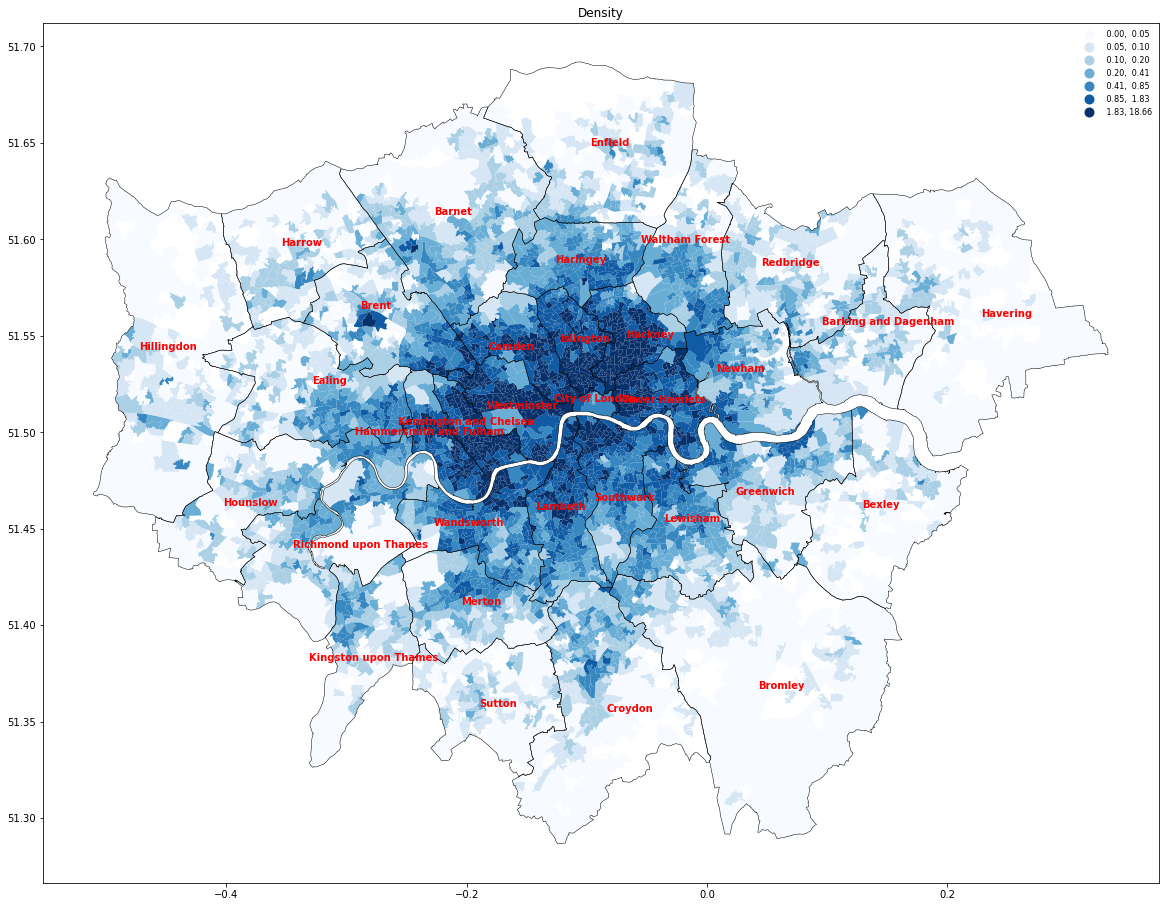

In [14]:
#London airbnb density plot
fig, ax = plt.subplots(1,1, figsize=(20,20))
airbnb_areas.plot(column='density',cmap='Blues', 
         scheme='quantiles', k=7, edgecolor='None', legend=True, legend_kwds={'frameon':False, 'fontsize':8}, linewidth=2.5, ax=ax)
boroughs['coords'] = boroughs['geometry'].apply(lambda x: x.representative_point().coords[:])
boroughs['coords'] = [coords[0] for coords in boroughs['coords']]
boroughs.plot(ax=ax, edgecolor='black', linewidth=0.5, facecolor='none')
for idx, row in boroughs.iterrows():
   plt.annotate(text=row['NAME'], xy=row['coords'], horizontalalignment='center', color='red',fontsize=10,weight='bold')
plt.title('Density')

### Entropy of Landuse

Text(0.5, 1.0, 'Entropy')

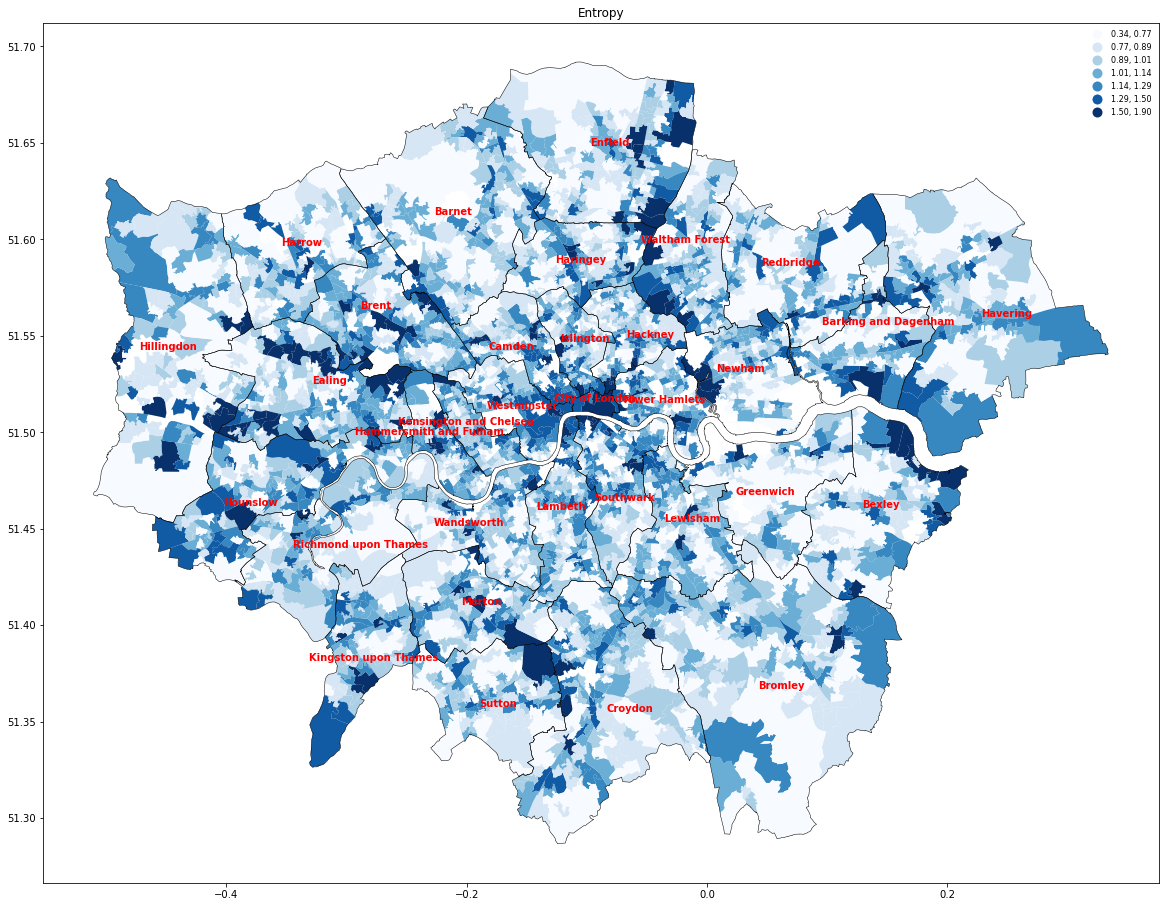

In [15]:
#London landuse entropy plot
fig, ax = plt.subplots(1,1, figsize=(20,20))
gdf.plot(column='entropy',cmap='Blues', 
         scheme='FisherJenks', k=7, edgecolor='None', legend=True, legend_kwds={'frameon':False, 'fontsize':8}, linewidth=1.5, ax=ax)
boroughs['coords'] = boroughs['geometry'].apply(lambda x: x.representative_point().coords[:])
boroughs['coords'] = [coords[0] for coords in boroughs['coords']]
boroughs.plot(ax=ax, linewidth=0.5, edgecolor='black', facecolor='none')
for idx, row in boroughs.iterrows():
   plt.annotate(text=row['NAME'], xy=row['coords'], horizontalalignment='center', color='red',fontsize=10,weight='bold')
plt.title('Entropy')

## Correlation

### Land Use, Entropy and Airbnb Listings

In [16]:
#Calculate the correlation coefficient
landuse_corr.corr()

,listing_counts,Community buildings,Leisure and recreational buildings,Defence,Industry,Offices,Retail,Storage and warehousing,Landfill and waste disposal,Minerals and mining,Institutional and communal accommo-dations,Residential,Highways and road transport,Transport (other),Utilities,entropy
listing_counts,1.000000,-0.096717,0.197007,0.000788,-0.020424,0.421170,0.206128,-0.030528,0.005995,-0.001229,0.117758,-0.251090,-0.082316,0.018175,-0.013670,0.072317
Community buildings,-0.096717,1.000000,0.013357,0.001002,0.026257,0.019815,0.026066,0.043407,0.007054,0.004907,0.055041,0.162594,0.258264,0.016944,0.051863,0.024257
Leisure and recreational buildings,0.197007,0.013357,1.000000,0.015570,0.038129,0.264388,0.284471,0.038470,0.018529,-0.002349,0.082170,0.037305,0.127630,0.001901,0.084831,0.170112
Defence,0.000788,0.001002,0.015570,1.000000,-0.002700,0.029424,0.014266,-0.000931,-0.002932,-0.001460,0.004925,0.005289,0.026592,-0.001563,0.004387,0.037243
Industry,-0.020424,0.026257,0.038129,-0.002700,1.000000,0.121387,0.156137,0.362299,0.139286,0.004435,0.007594,0.011953,0.263422,0.065671,0.271266,0.187042
Offices,0.421170,0.019815,0.264388,0.029424,0.121387,1.000000,0.593392,0.251933,0.051367,0.008389,0.182613,0.078612,0.356269,0.129417,0.192941,0.347861
Retail,0.206128,0.026066,0.284471,0.014266,0.156137,0.593392,1.000000,0.266211,0.135064,-0.002292,0.124252,0.110534,0.389389,0.098676,0.209396,0.400301
Storage and warehousing,-0.030528,0.043407,0.038470,-0.000931,0.362299,0.251933,0.266211,1.000000,0.250114,0.069673,0.023916,0.021887,0.356929,0.091683,0.444348,0.282180
Landfill and waste disposal,0.005995,0.007054,0.018529,-0.002932,0.139286,0.051367,0.135064,0.250114,1.000000,0.064870,0.007183,0.006177,0.123935,0.012291,0.246785,0.118329
Minerals and mining,-0.001229,0.004907,-0.002349,-0.001460,0.004435,0.008389,-0.002292,0.069673,0.064870,1.000000,0.120863,0.013751,0.128345,0.015320,0.014259,0.037195


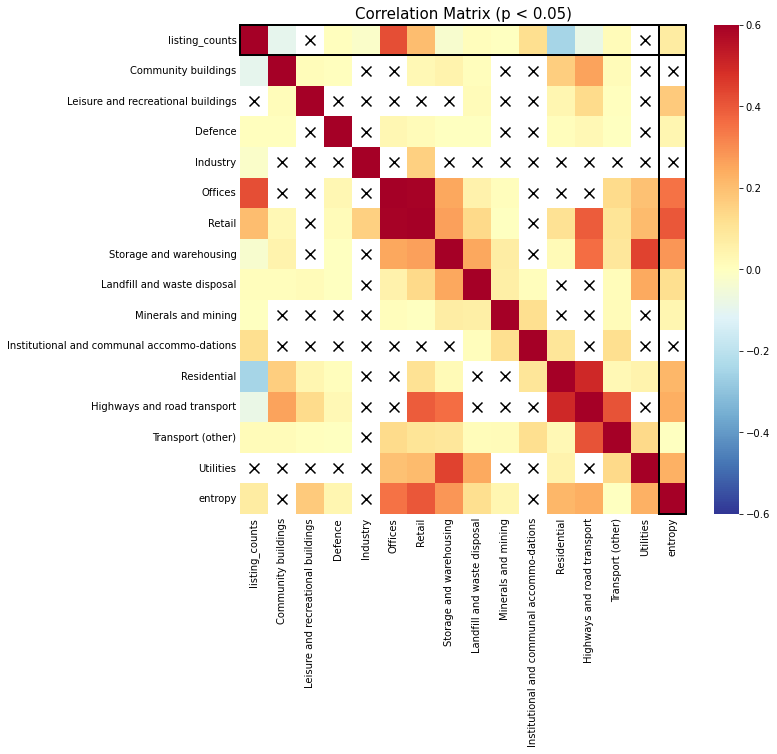

In [17]:
#Visualize the correlation matrix
#Set p-value at 0.05 to test significance
p_value = pd.DataFrame()
landuse_corr_dataframe = landuse_corr.corr()
for i in range(landuse_corr.shape[1]):
    for j in range(landuse_corr.shape[1]):
        statistic, pvalue = stats.pearsonr(landuse_corr[landuse_corr.columns.tolist()[i-1]], landuse_corr[landuse_corr.columns.tolist()[j-1]])
        p_value.at[i,j] = pvalue
        
p_value.columns = landuse_corr.columns

for i in range(landuse_corr.shape[1]):
    for j in range(landuse_corr.shape[1]):
        if p_value.iloc[i,j]>0.05:
            landuse_corr_dataframe.iloc[i,j] = np.nan

#Set visualization parameters            
points = pd.DataFrame(list(np.where(landuse_corr_dataframe.isna()))).T
points = points + 0.5
fig, ax = plt.subplots(1,1, figsize=(10,9))
heatmap = sns.heatmap(landuse_corr_dataframe, vmin=-0.6, vmax=0.6, cmap='RdYlBu_r',ax=ax)
plt.title('Correlation Matrix (p < 0.05)', fontsize=15)
wanted_label = landuse_corr.columns.tolist().index('entropy')
wanted_label2 = landuse_corr.columns.tolist().index('listing_counts')
x, y, w, h = wanted_label, 0, 1,landuse_corr.shape[1]
for _ in range(2):
    ax.add_patch(Rectangle((x, y), w, h, fill=False, edgecolor='black', lw=2, clip_on=False))
ax.tick_params(length=0)

x, y, w, h = 0, wanted_label2, landuse_corr.shape[1], 1
for _ in range(2):
    ax.add_patch(Rectangle((x, y), w, h, fill=False, edgecolor='black', lw=2, clip_on=False))
ax.tick_params(length=0)

for i in range(points.shape[0]):
    ax.scatter(*(points.iloc[i,:]), marker="x", color="black", s=100)

plt.show()

### Owernship, Entropy and Airbnb Listings

In [18]:
#Calculate the correlation coefficient
ownership_corr.corr()

,listing_counts,Owns outright,Owns with a mortgage or loan,Social rented,Private rented,entropy
listing_counts,1.000000,-0.305469,-0.353041,0.149259,0.355020,0.072317
Owns outright,-0.305469,1.000000,0.698968,-0.590781,-0.096356,0.088064
Owns with a mortgage or loan,-0.353041,0.698968,1.000000,-0.387216,-0.013612,0.172865
Social rented,0.149259,-0.590781,-0.387216,1.000000,0.088928,0.228695
Private rented,0.355020,-0.096356,-0.013612,0.088928,1.000000,0.497725
entropy,0.072317,0.088064,0.172865,0.228695,0.497725,1.000000


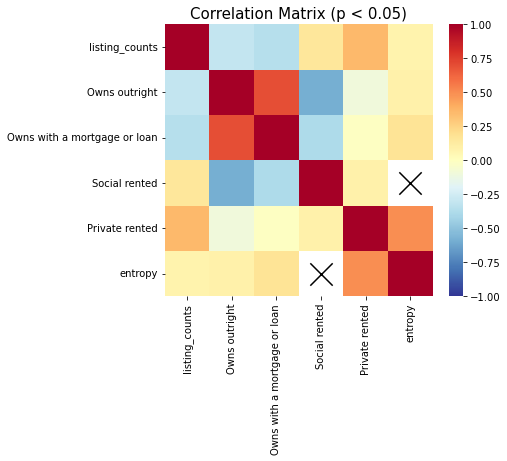

In [19]:
#Visualize the correlation matrix
#Set p-value at 0.05 to test significance
p_value = pd.DataFrame()
ownership_corr_dataframe = ownership_corr.corr()
for i in range(ownership_corr.shape[1]):
    for j in range(ownership_corr.shape[1]):
        statistic, pvalue = stats.pearsonr(ownership_corr[ownership_corr.columns.tolist()[i-1]], ownership_corr[ownership_corr.columns.tolist()[j-1]])
        p_value.at[i,j] = pvalue
        
p_value.columns = ownership_corr.columns

for i in range(ownership_corr.shape[1]):
    for j in range(ownership_corr.shape[1]):
        if p_value.iloc[i,j]>0.05:
            ownership_corr_dataframe.iloc[i,j] = np.nan

#Set visualization parameters             
points = pd.DataFrame(list(np.where(ownership_corr_dataframe.isna()))).T
points = points + 0.5

fig, ax = plt.subplots(1,1, figsize=(6,5))
heatmap = sns.heatmap(ownership_corr_dataframe, vmin=-1, vmax=1, cmap='RdYlBu_r',ax=ax)
plt.title('Correlation Matrix (p < 0.05)', fontsize=15)

for i in range(points.shape[0]):
    ax.scatter(*(points.iloc[i,:]), marker="x", color="black", s=500)

plt.show()